# Spektrální bisekce grafu

In [1]:
A = 2 * speye(6,6)

A[1, [2,3]] = [1,1]
A[2, [3,4]] = [1,1]
A[3, 6]     = 1
A[4, [5,6]] = [1,1]
A[5, 6]     = 1

A = A + transpose(A)
full(A)

6x6 Array{Float64,2}:
 4.0  1.0  1.0  0.0  0.0  0.0
 1.0  4.0  1.0  1.0  0.0  0.0
 1.0  1.0  4.0  0.0  0.0  1.0
 0.0  1.0  0.0  4.0  1.0  1.0
 0.0  0.0  0.0  1.0  4.0  1.0
 0.0  0.0  1.0  1.0  1.0  4.0

In [2]:
using PyPlot

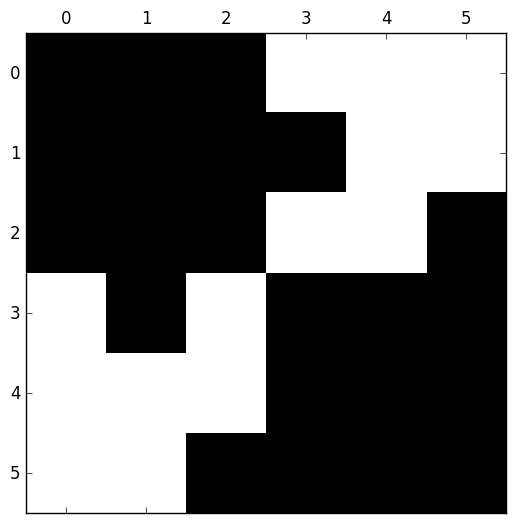

In [3]:
spy(A);

In [37]:
function incidence_matrix(A)
    n = size(A,1)
    m = div((nnz(A) - n), 2)
    E = spzeros(m,n)
    rows = rowvals(A)
    k = 1
    for i = 1:n
        for  l in nzrange(A,i)
            j = rows[l]
            if i < j
                E[k,i] = -1.
                E[k,j] =  1.
                k+=1
            end
        end
    end
    return E
end

incidence_matrix (generic function with 1 method)

In [36]:
E = incidence_matrix(A)
full(E)

23456789

8x6 Array{Float64,2}:
 -1.0   1.0   0.0   0.0   0.0  0.0
 -1.0   0.0   1.0   0.0   0.0  0.0
  0.0  -1.0   1.0   0.0   0.0  0.0
  0.0  -1.0   0.0   1.0   0.0  0.0
  0.0   0.0  -1.0   0.0   0.0  1.0
  0.0   0.0   0.0  -1.0   1.0  0.0
  0.0   0.0   0.0  -1.0   0.0  1.0
  0.0   0.0   0.0   0.0  -1.0  1.0

In [40]:
c = [1, -1, 1, -1, 1, -1]

6-element Array{Int64,1}:
  1
 -1
  1
 -1
  1
 -1

In [44]:
E*c

8-element Array{Float64,1}:
 -2.0
  0.0
  2.0
  0.0
 -2.0
  2.0
  0.0
 -2.0

In [43]:
dot(E*c,E*c)/4

5.0

In [39]:
L = transpose(E) * E
full(L)

6x6 Array{Float64,2}:
  2.0  -1.0  -1.0   0.0   0.0   0.0
 -1.0   3.0  -1.0  -1.0   0.0   0.0
 -1.0  -1.0   3.0   0.0   0.0  -1.0
  0.0  -1.0   0.0   3.0  -1.0  -1.0
  0.0   0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0  -1.0  -1.0  -1.0   3.0

In [49]:
eig(full(L))

([4.440892098500626e-15,1.0000000000000036,3.0,3.000000000000001,4.000000000000002,5.000000000000001],
6x6 Array{Float64,2}:
 -0.408248  -0.57735    0.5           0.288675  -0.408248  -1.66533e-16
 -0.408248  -0.288675  -0.5           0.288675   0.408248   0.5        
 -0.408248  -0.288675  -8.32667e-16  -0.57735    0.408248  -0.5        
 -0.408248   0.288675  -0.5           0.288675  -0.408248  -0.5        
 -0.408248   0.57735    0.5           0.288675   0.408248   9.99201e-16
 -0.408248   0.288675   0.0          -0.57735   -0.408248   0.5        )

## Příklad 2